In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import torchvision.transforms as T
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from pathlib import Path

%matplotlib inline

In [3]:
train = Path(r'C:\Users\USER-PC\Documents\Data Science\data set\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train')
val =Path(r'C:\Users\USER-PC\Documents\Data Science\data set\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\valid')

In [4]:
from torchvision.datasets import ImageFolder

In [5]:
image_size = 64
stats = ((0.5, 0.45, 0.425), (0.35, 0.45, 0.253))

In [9]:
dataset = ImageFolder(train, transform = T.Compose([T.CenterCrop(image_size), T.Resize(image_size),
                                                    T.ToTensor(), T.Normalize(*stats)]))
validation_set = ImageFolder(val, transform = T.Compose([T.CenterCrop(image_size), T.Resize(image_size),
                                                         T.ToTensor(), T.Normalize(*stats)]))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\USER-PC\\Documents\\Data Science\\data set\\New Plant Diseases Dataset(Augmented)\\New Plant Diseases Dataset(Augmented)\\train'

In [10]:
print(len(dataset.classes))
dataset.classes

NameError: name 'dataset' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label Apple___Apple_scab : 0
torch.Size([3, 32, 32])


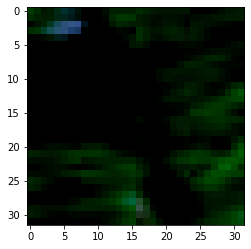

In [7]:
img, label = dataset[0]
print("label", dataset.classes[label], ':', label)
print(img.shape)
plt.imshow(img.permute(1, 2, 0))

In [8]:
random_seed = 20
torch.manual_seed(random_seed)
batch_size = 250

In [9]:
len(dataset), len(validation_set)

(70295, 17572)

In [10]:
train_loader = DataLoader(dataset, batch_size, shuffle= True, collate_fn=None, num_workers=4, pin_memory = True)
val_loader = DataLoader(validation_set, batch_size=batch_size*2, num_workers=3, collate_fn=None, pin_memory=True)

In [11]:
def showbatch(data):
    for image, label in data:
        fig, ax = plt.subplots(figsize = (16, 8))
        plt.xticks([]); plt.yticks([])
        plt.imshow(make_grid(image, nrow=16).permute(1, 2, 0))
        break

C:\Users\USER-PC\anaconda3.8\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


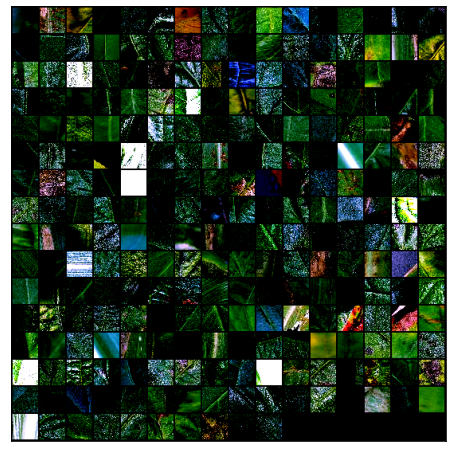

In [12]:
showbatch(train_loader)

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim =1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [14]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        batch_accuracies = [x['val_acc'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        epoch_accuracy = torch.stack(batch_accuracies).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_accuracy.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch[{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [15]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
torch.cuda.is_available()

False

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [18]:
device = get_default_device()
device

device(type='cpu')

In [19]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title("Loss Vs. No of epoochs")

In [21]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title("Accuracy Vs. No of epochs")

In [22]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [23]:
input_size = 3*32*32
hidden_size1 = 1024
hidden_size2 = 512 
hidden_size3 = 256
hidden_size4 = 128
hidden_size5 = 64
output_size = 38
batch_size = 500

In [24]:
class PlantDiseaseModel(ImageClassificationBase):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        self.linear4 = nn.Linear(hidden_size3, hidden_size4)
        self.linear5 = nn.Linear(hidden_size4, hidden_size5)
        self.linear6 = nn.Linear(hidden_size5, output_size)

        
    def forward(self, xb):
        out = xb.view(xb.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out

In [25]:
model = to_device(PlantDiseaseModel(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, 
                                    output_size), device)

In [26]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 3.6417698860168457, 'val_acc': 0.02411111257970333}]

In [27]:
history += fit(10, 0.1, model, train_loader, val_loader)

Epoch[0], val_loss: 3.2491, val_acc: 0.1159
Epoch[1], val_loss: 3.0911, val_acc: 0.1507
Epoch[2], val_loss: 2.8307, val_acc: 0.1895
Epoch[3], val_loss: 2.8181, val_acc: 0.1928
Epoch[4], val_loss: 2.7305, val_acc: 0.2178


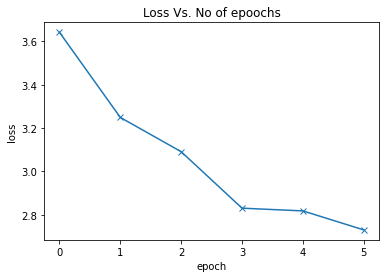

In [28]:
plot_losses(history)

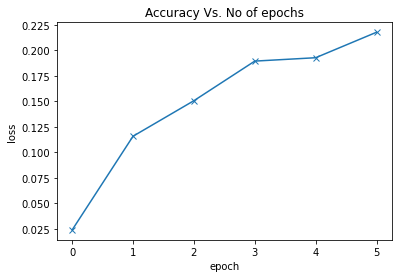

In [29]:
plot_accuracies(history)

In [30]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Apple___Apple_scab , Predicted:  Apple___Black_rot


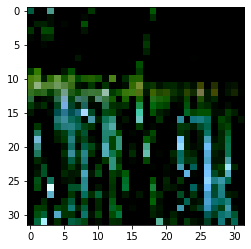

In [31]:
img, label = dataset[100]
plt.imshow(img.permute(1, 2, 0))
print("Label: ", dataset.classes[label], ", Predicted: ", predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label Potato___Early_blight , Predicted Potato___Early_blight


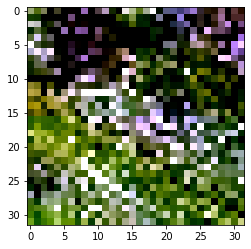

In [32]:
img, label = dataset[38000]
plt.imshow(img.permute(1, 2, 0))
print("Label", dataset.classes[label], ", Predicted", predict_image(img, model))

In [ ]:
val_loader = DataLoader(val_loader, batch_size*2, shuffle = True, num_workers = 4, collate_fn = None, pin_memory = True)
result = evaluate(model, val_loader)
result

# CNN

In [ ]:
class PlantDiseaseCNNModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model2 = SurfaceDetectionCNNModel()
model2

In [ ]:
evaluate(model2, val_loader)

In [ ]:
def predict_image(img, model2):
    xb = to_device(img.unsqueeze(0), device)
    yb = model2(xb)
    _, preds = torch.max(yb, dim = 1)
    return dataset.classes[preds[0].item()]

In [ ]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.1

In [ ]:
history += fit(num_epochs, lr, model2, train_loader, val_loader, opt_func)
history

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

In [ ]:
img, label = dataset[0]
plt.imshow(img.permute(1, 2, 0))
print("Label", dataset.classes[label], " , Predicted", predict_image(img, model2))

In [ ]:
img, label = dataset[2000]
plt.imshow(img.permute(1, 2, 0))
print("Label", dataset.classes[label], " , Predicted", predict_image(img, model2))

In [ ]:
img, label = dataset[15000]
plt.imshow(img.permute(1, 2, 0))
print("Label", dataset.classes[label], " , Predicted", predict_image(img, model2))

In [ ]:
val_loader = DataLoader(val, batch_size*3, shuffle = True, num_workers = 3, collate_fn = None, pin_memory = True)
result = evaluate(model2, val_loader)
result